In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Introduction
Overall aim is to determine if we can estimate the income of a user, using the income of the people with the same employer, thereby increasing the number of users we could be serving. For the purposes of analysis, the employers having > 10 of our users are considered.

In [1]:
import django
import os
import sys
from uuid import UUID

sys.path.append("<path to Django folder>")
os.environ.setdefault(
    "DJANGO_SETTINGS_MODULE", "config.settings.base")
django.setup()

import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

In [2]:
import scipy as sp
import scipy.stats
from scipy.stats.stats import pearsonr

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from utils.models import BoostUser, BoostLoan, BoostEmployer
from nirnay.models import CreditAssessment

### Notes
Of the users who applied for a loan for the top employers, roughly 30% of the users have an estimate. We can use the estimates of these users to make an approximation of the the remaining users salary.

#### Notes (from previous):
1. About 118 firms employ more that 10 of the users who had their credit assessed in 2017. Athough this number includes potential duplicates.
2. These firms employ about 3300 users out of a potential 33K assessments. Out of these 3300, only 600 have a salary estimate.

In [49]:
print("Employers with more than 20 employees:", top_employers[top_employers['total_users']>=20].shape[0])
print("Employees under them:", top_employers[top_employers['total_users']>=20].total_users.sum())
print("Employees with user estimate:", top_employers[top_employers['total_users']>=20].users_with_estimate.sum())

Employers with more than 20 employees: 55
Employees under them: 2376
Employees with user estimate: 498.0


<h3 align="center">Income Estimate</h3>

In [6]:
42261/30888

1.3682012432012431

In [7]:
7760/895

8.670391061452515

In [8]:
34500/29992

1.1503067484662577

#### Notes:
1. From 1st Jan to 30th March 2017, there are 42,261 users who entered their employer and there are 30,888 distinct employers spread amongst them. That's an average of 1.36 users per employer. 
2. Of these users, if we consider only companies present in "boostEmployers", there are 7760 users working with 895 employers. An average of 8.67 users per employer.
3. If we exclude the companies present in "boostEmployer", there are 34500 users working with 29992 employers at an average of 1.15 users per employer.

Queries:
1. select count(*), count(distinct employer) from "boostUsers" where "createdAt"::date >= '2017-01-01' and employer is not null and lower(employer) not in ('uber', 'ola', 'paysense', 'other', 'others', 'self', 'self employed');

2. select count(*), count(distinct employer) from "boostUsers" where "createdAt"::date >= '2017-01-01' and employer is not null and lower(employer) not in ('uber', 'ola', 'paysense', 'other', 'others', 'self', 'self employed') and lower(employer) in (select lower(name) from "boostEmployers");

3. select count(*), count(distinct employer) from "boostUsers" where "createdAt"::date >= '2017-01-01' and employer is not null and lower(employer) not in ('uber', 'ola', 'paysense', 'other', 'others', 'self', 'self employed') and lower(employer) not in (select lower(name) from "boostEmployers");

Since majority of the coworkers come from the employers available in the boostEmployer, only those employers are being considered for further analysis

<h3 align="center">Deviations within each of the Employers</h3>

Let's check how the incomes of the users vary within each of the employers. The main objective is to find out if we can find any cutoff variance below which we can say that the distribution has a central tendency and low spread.

In [9]:
user_assessments = pd.DataFrame(list(CreditAssessment.objects.filter(
            is_approved_flexi=True, created_at__gte=datetime(2017,1,1)).order_by(
            'master_user_id','-created_at').distinct('master_user_id').values(
            'master_user_id','stated_income','salary_estimate', 'cibil_score','bank_sms_count', 
            'perfios_salary_estimate', 'salary_in_payslip', 'age')))

In [10]:
users = pd.DataFrame(list(BoostUser.objects.filter(
            master_user_id__in=user_assessments.master_user_id).values('master_user_id','employer', 'salary_in_salary_payslip')))

In [11]:
users['salary_in_salary_payslip'] /= 100

In [12]:
users[users.salary_in_salary_payslip.notnull()].shape, users.shape

((1479, 3), (23016, 3))

In [13]:
boost_employers = list(BoostEmployer.objects.values_list('name', flat=True))

In [14]:
user_assessments[user_assessments.salary_estimate.notnull()].shape, user_assessments[user_assessments['salary_in_payslip'].notnull()].shape

((3720, 8), (309, 8))

In [15]:
user_assessments = user_assessments.merge(users, on='master_user_id', how='left')

In [16]:
user_assessments.drop(['salary_in_payslip'], axis=1, inplace=True)

In [17]:
user_employers = user_assessments[user_assessments['employer'].isin(boost_employers)]

In [18]:
user_employers = user_employers[(user_employers['employer']!='PAYSENSE') & 
                                (user_employers['employer']!='UBER') & 
                                (user_employers['employer']!='OLA') & 
                                (~user_employers['employer'].str.contains('OTHER')) & 
                                (~user_employers['employer'].str.contains('SELF'))]

In [19]:
user_employers['actual_income'] = user_employers.apply(lambda x: x['salary_in_salary_payslip'] if 
                                                       pd.notnull(x['salary_in_salary_payslip']) 
                                                       else x['salary_estimate'], axis=1)

In [20]:
user_employers[user_employers.actual_income.notnull()].shape

(816, 10)

In [21]:
top_employers = user_employers.employer.value_counts()[:500].index.values
top_employers = pd.DataFrame(top_employers, columns=['employer'])

Let's consider the top 500 employers of 2017 in BoostEmployer

In [22]:
def median_absolute_deviation(arr):
    med = np.median(arr)
    return np.median(np.abs(arr - med))

In [23]:
def get_user_employer(master_user_id):
    employer = BoostUser.objects.filter(master_user_id=master_user_id).values_list('employer',flat=True).get()
    return employer

In [24]:
def get_coworkers(employer):
    try:
        BoostEmployer.objects.filter(name__iexact=employer).get()
        co_workers = list(BoostUser.objects.filter(employer__iexact=employer).values_list(
                'master_user_id', flat=True))
        return list(co_workers)
    except BoostEmployer.DoesNotExist:
        return []

In [25]:
def get_user_salary_estimates(master_user_ids):
    salary_estimates = pd.DataFrame(list(CreditAssessment.objects.filter(master_user_id__in=master_user_ids).order_by(
        'master_user_id', '-created_at').distinct('master_user_id').values('master_user_id','salary_estimate', 'age')))
    salary_in_payslip = pd.DataFrame(list(BoostUser.objects.filter(
        master_user_id__in=master_user_ids).values('master_user_id','salary_in_salary_payslip')))
    salary_in_payslip['salary_in_salary_payslip'] /= 100
    actual_incomes = pd.merge(salary_estimates, salary_in_payslip, on='master_user_id', how='outer')
    actual_incomes['actual_income'] = actual_incomes.apply(lambda x: x['salary_in_salary_payslip'] if 
                                                       pd.notnull(x['salary_in_salary_payslip']) 
                                                       else x['salary_estimate'], axis=1)
    actual_incomes = actual_incomes[actual_incomes['actual_income'].notnull()]
    employee_ages = actual_incomes['age'].tolist()
    actual_incomes = actual_incomes['actual_income'].tolist()
    if len(actual_incomes)>=5:
        return actual_incomes, employee_ages
    else:
        return [], []

In [26]:
def get_employee_salary(employer):
    employees = get_coworkers(employer)
    employee_income_age =  get_user_salary_estimates(employees)
    incomes = employee_income_age[0]
    return incomes

In [27]:
def get_employee_age(employer):
    employees = get_coworkers(employer)
    employee_income_age =  get_user_salary_estimates(employees)
    ages = employee_income_age[1]
    return ages

In [28]:
top_employers['incomes'] = top_employers['employer'].apply(get_employee_salary)
top_employers['ages'] = top_employers['employer'].apply(get_employee_age)

In [29]:
top_employers['number_of_income_cases'] = top_employers['incomes'].apply(lambda x: len(x))

In [30]:
top_employers['median_income'] = top_employers['incomes'].apply(lambda x: np.nan_to_num(np.median(x)))
top_employers['standard_deviation'] = top_employers['incomes'].apply(lambda x: int(np.nan_to_num(np.std(x))))
top_employers['median_absolute_deviation'] = top_employers['incomes'].apply(median_absolute_deviation)

In [31]:
top_employers['deviation_factor'] = top_employers['median_absolute_deviation']/top_employers['median_income']

Calculating the median absolute deviation of the estimated incomes for each employer. The "Deviation Factor" is another measure which normalizes the median deviation with respect to the median income. 

Deviation Factor = median_absolute_deviation / median_income

In [32]:
top_employers.head(2)

,employer,incomes,ages,number_of_income_cases,median_income,standard_deviation,median_absolute_deviation,deviation_factor
0,TATA CONSULTANCY SERVICES LIMITED,"[32741.0, 35000.0, 45590.0, 120000.0, 25800.0,...","[28, 28, 33, 51, 26, 24, 29, 28, 31, 26, 30, 3...",161,31109.0,14914,6827.0,0.219454
1,TEAM LEASE,"[27513.0, 12610.0, 22190.0, 17440.0, 12441.0, ...","[29, 27, 28, 26, 27, 29, 34, 41, 37, 23, 30, 2...",76,19096.5,10766,2975.0,0.155788


#### Plotting this "Deviation Factor" across the top 500 employers:

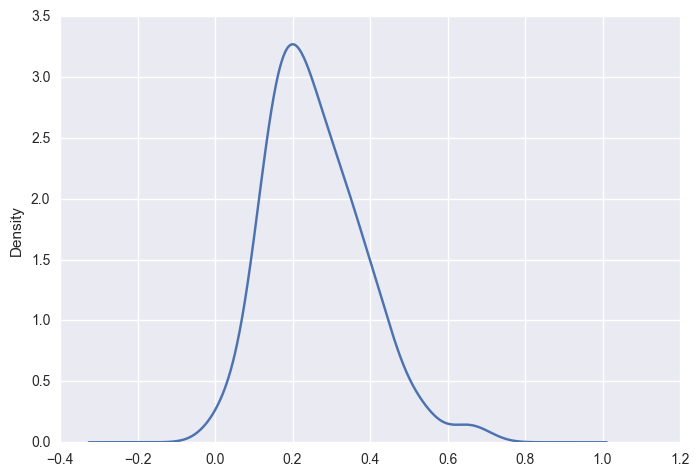

In [33]:
top_employers[top_employers['deviation_factor']>0]['deviation_factor'].plot(kind='kde')

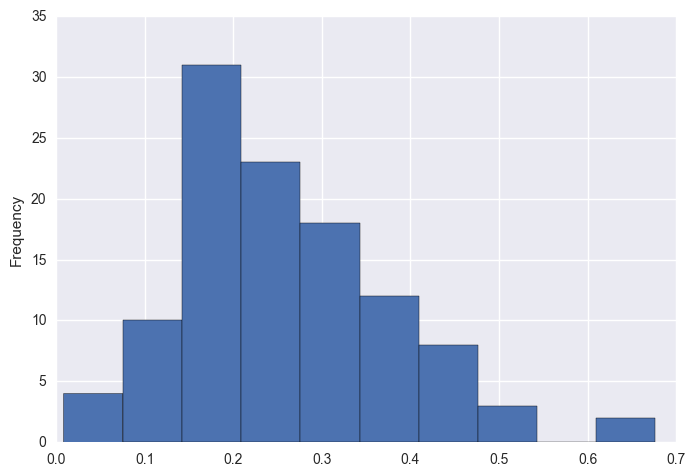

In [34]:
top_employers['deviation_factor'].plot(kind='hist', bins=10)

From the above distribution, it can be observed that majority of the employers have a deviation factor of 0.1 to 0.4 (peaking at ~0.2).
<br>This can be interpreted as : For majority of the employers, half of the employees' salaries lie within a distance of 40% from the median value = median * (1 +- 0.4)

We can use this range as a limiting factor on the predictability of incomes for an individual employer.

#### Understanding the relation of the incomes with age

Let's calculate the correlation coeff between user's incomes and ages for every employer

In [35]:
top_employers['income_age_corr'] = top_employers.apply(lambda x: pearsonr(x['incomes'], x['ages'])[0], axis=1)
top_employers['p-value'] = top_employers.apply(lambda x: np.round(pearsonr(x['incomes'], x['ages'])[1], 4), axis=1)

The incomes for an employer are only being returned if there are atleast 5 values to return.

In [36]:
top_employers.head(2)

,employer,incomes,ages,number_of_income_cases,median_income,standard_deviation,median_absolute_deviation,deviation_factor,income_age_corr,p-value
0,TATA CONSULTANCY SERVICES LIMITED,"[32741.0, 35000.0, 45590.0, 120000.0, 25800.0,...","[28, 28, 33, 51, 26, 24, 29, 28, 31, 26, 30, 3...",161,31109.0,14914,6827.0,0.219454,0.613343,0.0000
1,TEAM LEASE,"[27513.0, 12610.0, 22190.0, 17440.0, 12441.0, ...","[29, 27, 28, 26, 27, 29, 34, 41, 37, 23, 30, 2...",76,19096.5,10766,2975.0,0.155788,0.166639,0.1502


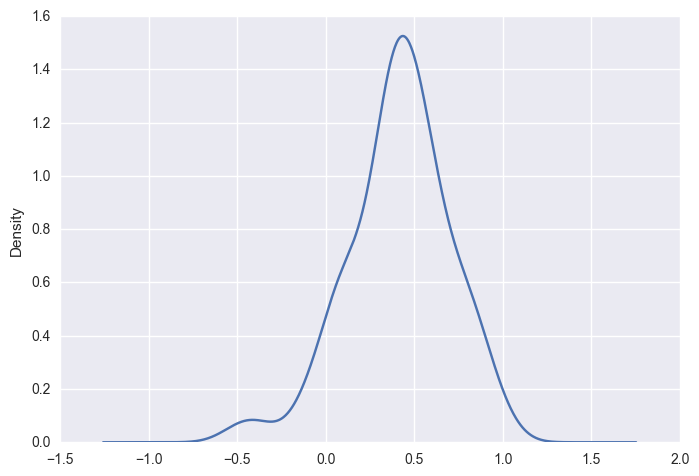

In [37]:
top_employers['income_age_corr'].plot(kind='kde')

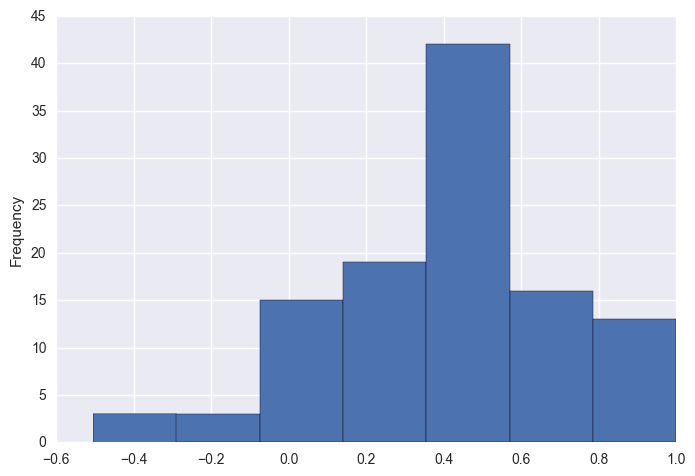

In [38]:
top_employers['income_age_corr'].plot(kind='hist', bins=7)

Plotting the density and distribution plots of the correlation between incomes and ages across employers, we can observe that the correlation is positive and approximately > 0.5 for a majority of the employers.

To get the thresholds, we can look at the correlation between incomes and ages of all the users across the employers

In [39]:
overall_incomes = list(itertools.chain.from_iterable(top_employers.incomes.tolist()))
overall_ages = list(itertools.chain.from_iterable(top_employers.ages.tolist()))

In [40]:
len(overall_incomes), len(overall_ages)

(2643, 2643)

In [41]:
income_age_correlation = pearsonr(overall_incomes, overall_ages)[0]
income_age_significance = pearsonr(overall_incomes, overall_ages)[1]

In [42]:
income_age_correlation, income_age_significance

(0.33269021880986155, 2.4948121232701303e-69)

The above figures show that the correlation coefficient between overall incomes and overall ages is ~0.34. The p-value is < 0.05 which could say that there is a significant relationship between age and income (and a positive relation)

We can use the correlation of overall distributions (0.34) as a cutoff. 
<br>
#### The final approach could possibly be:
1. For a set of available estimates from an employer, if there are too many incomes available, we can try and use the age of the user to identify the similar set of coworkers.
2. This subsetting would be done only for the employers for which there is a positive correlation between the age and income, and if the p-value of such an estimate is < 0.05 (statistically significant)
3. Once we identify the similar users (wherever applicable), we return the median income for the employer where the deviation factor (calculated as described previously on the entire data of the employer) is < 0.4

Now to identify the similar users for each user based on the age, we can divide the users into bins of age groups. The below figure represents a histogram of the age of all the users (of 2017) and who are employed by one of the boostEmployer.

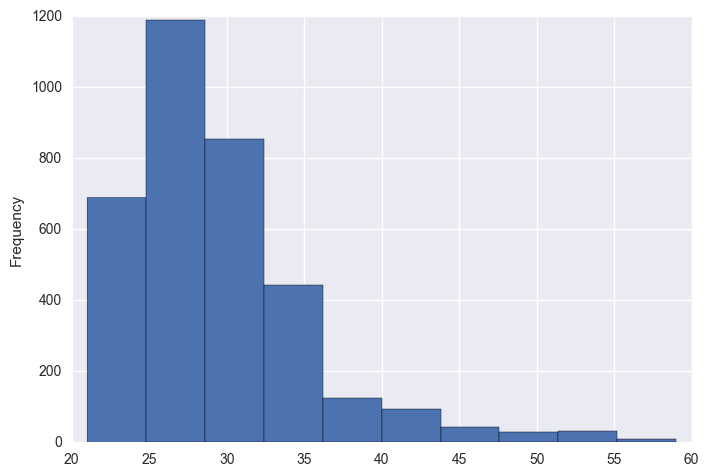

In [43]:
user_employers.age.plot(kind='hist')

It can be observed that most of the users are in the age group of 20-35 years (inline with expectation). To segment these users, we can split the ages into groups of size 5 years. The bins would be basically be as follows:
<br><br>
[0, 20, 25, 30, 35, 100]

In [44]:
# bins = [0, 20, 25, 30, 35, 100]
# np.digitize([0, 100], bins)

In [45]:
top_employers

,employer,incomes,ages,number_of_income_cases,median_income,standard_deviation,median_absolute_deviation,deviation_factor,income_age_corr,p-value
0,TATA CONSULTANCY SERVICES LIMITED,"[32741.0, 35000.0, 45590.0, 120000.0, 25800.0,...","[28, 28, 33, 51, 26, 24, 29, 28, 31, 26, 30, 3...",161,31109.0,14914,6827.0,0.219454,0.613343,0.0000
1,TEAM LEASE,"[27513.0, 12610.0, 22190.0, 17440.0, 12441.0, ...","[29, 27, 28, 26, 27, 29, 34, 41, 37, 23, 30, 2...",76,19096.5,10766,2975.0,0.155788,0.166639,0.1502
2,WIPRO LIMITED,"[14613.0, 30991.0, 29970.0, 18355.0, 21440.0, ...","[25, 29, 25, 32, 28, 28, 23, 25, 32, 24, 29, 3...",128,21434.0,19701,6650.0,0.310255,0.464249,0.0000
3,3M INDIA LIMITED,"[20000.0, 28000.0, 11750.0, 21897.0, 25000.0, ...","[25, 39, 29, 27, 21, 26, 27, 32, 42, 32, 36, 3...",15,21897.0,11660,3186.0,0.145499,0.324490,0.2380
4,RELIANCE JIO,"[16413.0, 20246.0, 17036.0, 15297.0, 15904.0, ...","[23, 27, 30, 21, 29, 26, 34, 30, 25, 32, 34, 2...",45,17089.0,14900,2494.0,0.145942,0.098599,0.5193
5,BHARTI AIRTEL LIMITED,"[15038.0, 15000.0, 84323.0, 15389.0, 19140.0, ...","[26, 27, 28, 24, 27, 28, 35, 27, 29, 24, 31, 3...",42,21230.5,16832,5480.5,0.258143,0.402840,0.0082
6,ICICI BANK LIMITED,"[23764.0, 18524.0, 17227.0, 39196.0, 21495.0, ...","[30.0, 29.0, 24.0, 31.0, 29.0, 31.0, 26.0, 29....",87,24482.0,18015,9311.0,0.380320,0.375850,0.0003
7,GEBBS HEALTHCARE,"[15297.0, 127400.0, 53719.0, 31060.0, 43390.0,...","[35, 40, 24, 30, 32, 25, 25, 26, 36, 26, 28, 2...",60,22917.0,18965,7576.5,0.330606,0.486987,0.0001
8,HDFC BANK LIMITED,"[13963.0, 54145.0, 14700.0, 37609.0, 39500.0, ...","[23, 34, 21, 26, 27, 38, 26, 35, 26, 31, 26, 2...",63,24000.0,13995,8129.0,0.338708,0.466021,0.0001
9,IBM,"[53636.0, 65874.0, 84800.0, 49867.0, 35200.0, ...","[33, 30, 27, 30, 27, 26, 37, 25, 33, 29, 38, 2...",71,33666.0,20393,13188.0,0.391731,0.510228,0.0000
